# Sentiment 140
Download links:
Glove dataset (gebruik glove.6B.zip):
https://nlp.stanford.edu/projects/glove/
of kaggle (100d dataset)
https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation?select=glove.6B.100d.txt

### Load data

In [240]:
import re
import nltk
import numpy as np
import pandas as pd
from keras_preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
#download stopwords when it's not on the computer yet
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.framework.test_util import is_gpu_available
from tensorflow.python.keras import Sequential, Input, Model
from tensorflow.python.keras.layers import Bidirectional, LSTM, Dropout, Dense, SpatialDropout1D, Conv1D, Embedding
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
from wordcloud import WordCloud
from keras.preprocessing.sequence import pad_sequences
import pydot
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [241]:
def prepare_data(file):
    data = pd.read_csv(file,encoding="latin")
    data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
    return data


In [242]:
train = prepare_data("training.1600000.processed.noemoticon.csv")
test = prepare_data("testdata.manual.2009.06.14.csv")

train.head()

,sentiment,id,date,query,user_id,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### Verwijder onnodige data
Omdat we gaan kijken naar de sentiment zijn bepaalde waarden nu al niet belangrijk. Wat we nodig hebben is de sentiment
waarde en de tekst.

In [243]:
train.drop(columns=['id', 'date','query','user_id'])
test.drop(columns=['id', 'date','query','user_id'])

,sentiment,text
0,4,Reading my kindle2... Love it... Lee childs i...
1,4,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,@kenburbary You'll love your Kindle2. I've had...
3,4,@mikefish Fair enough. But i have the Kindle2...
4,4,@richardebaker no. it is too big. I'm quite ha...
...,...,...
492,2,Ask Programming: LaTeX or InDesign?: submitted...
493,0,"On that note, I hate Word. I hate Pages. I hat..."
494,4,Ahhh... back in a *real* text editing environm...
495,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [244]:
train.head()

,sentiment,id,date,query,user_id,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Remove the 2 sentiment value

In [245]:
print(test["sentiment"].unique())
test = test[test.sentiment != 2]

[4 0 2]


Uit informatie dat gegeven is de waarde 0 negatief en de waarde 4 positief.

## NLP Implementation
Verwijder de stopwoorden voor engelse taal:

In [246]:
print("Predefine variables before the function to save workload")
en_stopwords = stopwords.words('english')
print("stopwords")
print(en_stopwords)
stemmer = SnowballStemmer('english')
regex="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess_text(text,stem=False):
    text = re.sub(regex, ' ', str(text).lower()).strip()
    words = []
    for word in text.split():
        if word not in en_stopwords:
            if stem:
                words.append(stemmer.stem(word))
            else:
                words.append(word)
    return " ".join(words)

Predefine variables before the function to save workload
stopwords
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some',

In [247]:
train.text = train.text.apply(lambda x: preprocess_text(x))
train.head()

,sentiment,id,date,query,user_id,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,whole crew


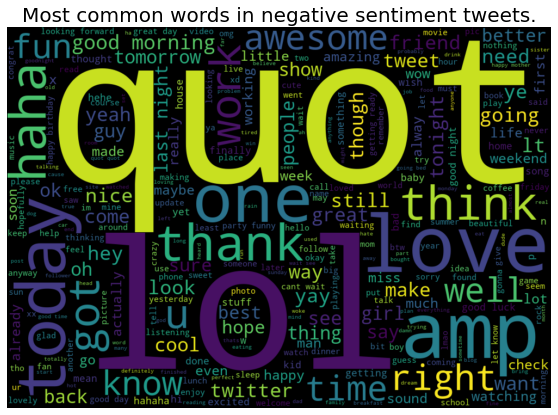

In [248]:
plt.figure(figsize=(14,7))
# Positive word cloud
pwc = WordCloud(max_words=300, width=1000, height=700).generate(" ".join(train[train["sentiment"]==4]["text"]))
plt.imshow(pwc,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

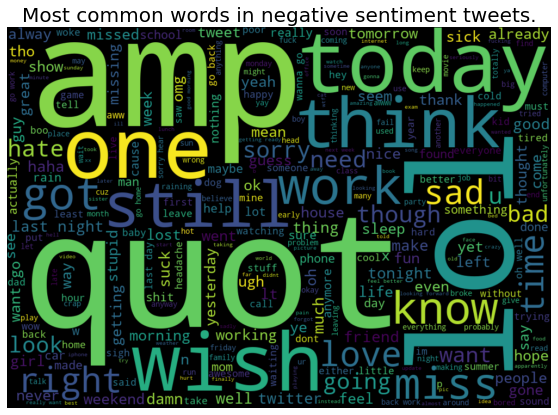

In [249]:
plt.figure(figsize=(14,7))
# Positive word cloud
pwc = WordCloud(max_words=300, width=1000, height=700).generate(" ".join(train[train["sentiment"]==0]["text"]))
plt.imshow(pwc,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

## Embed layer
Create embedded layer for forward learning and possibly better results

In [250]:
emb_dict = dict()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)
glove_txt = open('./glove.6B.100d.txt',encoding='utf8')
max_len = 50
for line in glove_txt:
    rec = line.split()
    word = rec[0]
    vector_dimentsions = np.asarray(rec[1:], dtype='float32')
    emb_dict[word] = vector_dimentsions

# Sluit file af
glove_txt.close()

In [251]:
output_dim = 100
vocab_size = len(tokenizer.word_index) +1
matrix = np.zeros((vocab_size,output_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = emb_dict.get(word)
    if embedding_vector is not None:
        matrix[index] = embedding_vector

In [252]:
y_train = train.sentiment
y_train = y_train.replace(4,1)
y_test =  test.sentiment
y_test = y_test.replace(4,1)
train_seq = tokenizer.texts_to_sequences(train.text)
test_sq = tokenizer.texts_to_sequences(test.text)
X_train = pad_sequences(train_seq, maxlen=max_len,padding='post')
X_test = pad_sequences(test_sq, maxlen=max_len,padding='post')

In [253]:
print(y_train.unique())
print(y_test.unique())

[0 1]
[1 0]


In [254]:
# Create the actual layer
embed_layer = Embedding(vocab_size,
                        output_dim,
                        input_length=max_len,
                        weights=[matrix],
                        trainable=False)

## Create model
Voor het model wordt er een Bidirectionele LSTM laag gebruikt hiermee worden twee LSTM lagen naast elkaar gelegd en
wordt de eerste keer heen door de eerste laag en daarna terug door de tweede laag. Dit kost wel meer computer kracht,
maar heeft vaak goede resultaten opgeleverd voor modellen die iets met zinnen/taal moeten verwerken.
Daarbij worden Dropout layers gebruikt om overfitting te voorkomen.

In [255]:
# Create custom model
input_seq = Input(shape=(max_len,), dtype='int32')
embed_seq = embed_layer(input_seq)
x = SpatialDropout1D(0.2)(embed_seq)
x = Conv1D(64,5, activation='relu')(x)
x = Bidirectional(LSTM(100,return_sequences=True, recurrent_dropout=0.2))(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(input_seq, output)

In [256]:
# plot_model(model,show_shapes=True)

In [257]:
model.compile(optimizer=Adam(0.001),loss='binary_crossentropy', metrics=["accuracy"])

In [258]:
history = model.fit(X_train, y_train, batch_size=3000, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
800/800 [==============================] - 975s 1s/step - loss: 0.5829 - accuracy: 0.6852 - val_loss: 0.4479 - val_accuracy: 0.7935

## Resultaten

In [259]:
predictions = model.predict(X_test)
predictions.shape

(358, 46, 1)

In [260]:
test_predictions = predictions
prediction_fl = test_predictions.flatten()
prediction_fl = (prediction_fl>0.5)
accuracy_score(prediction_fl, y_test)

0      1
1      1
2      1
3      1
4      1
      ..
491    1
493    0
494    1
495    0
496    0
Name: sentiment, Length: 358, dtype: int64

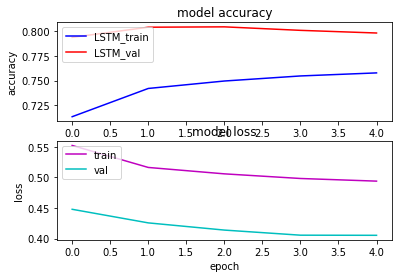

In [261]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

## Conclusie
Met het trainen is de loss en de accuracy beter geworden. Ik denk dat er mogelijk betere resultaten uit zouden
komen met meer training en aanpassingen in het model. Aangezien de training sets al super lang duren, houd ik het bij
de toepassing van Bidirectional LSTM, forward learning en het gebruik van taalmodellen.

Ik vond dit een van de lastigste modellen om te maken omdat ik hier nog helemaal geen ervaring mee had.
Daarnaast was het super interessant om word fields te maken en tokenizers.